In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc as misc 
from scipy.signal import resample

import optimusprimal as opt
import optimusprimal.primal_dual as primal_dual
import optimusprimal.grad_operators as grad_operators
import optimusprimal.linear_operators as linear_operators
import optimusprimal.prox_operators as prox_operators

2023-01-30 16:05:45.544653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


First, we need to define some heuristics for the solver, these include:

      - tol: convergence criteria for the iterations
      - iter: maximum number of iterations
      - update_iter: iterations between logging iteration diagnostics
      - record_iters: whether to record the full diagnostic information



In [2]:
options = {"tol": 1e-5, "iter": 1500, "update_iter": 50, "record_iters": False}

Next, we simulate a standard de-noising setting by contaminating a known
signal $x$ with some Gaussianly distributed noise. Note that for simplicity the
measurement operator here is taken to be the identity operator.


In [3]:
ISNR = 25.0                                            # Input signal to noise ratio
sigma = 10 ** (-ISNR / 20.0)                           # Noise standard deviation
print('sigma: ', sigma)
reg_param = 2.5                                        # Regularisation parameter
res = 256                                              # Resolution we want to work with

x = misc.ascent()                                      # Scipy's ascent benchmark image
for i in range(2):
    x = resample(x, axis=i, num=res)
x /= np.nanmax(x)                                      # Normalise image

n = np.random.normal(0, sigma, x.shape)                # Random Gaussian noise
y = x + n                                              # Simulated observations y

sigma:  0.05623413251903491


/var/folders/zc/g9pg19x15rg0rz8wcsr79645xjx6sw/T/ipykernel_13904/854899095.py:7: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  x = misc.ascent()                                      # Scipy's ascent benchmark image


## Primal-dual FB Wavelet-based denoiser

In [4]:
# Define the grad
g = grad_operators.l2_norm(sigma, y, linear_operators.identity())
g.beta = 1.0 / sigma ** 2

# Define the wavelet dict
wav = ["db1", "db4"]                                     # Wavelet dictionaries to combine
levels = 4                                               # Wavelet levels to consider [1-6]
psi = linear_operators.dictionary(wav, levels, x.shape)  # Wavelet linear operator

# Define the l1 norm prox with the dict psi
h = prox_operators.l1_norm(np.max(np.abs(psi.dir_op(y))) * reg_param, psi)
h.beta = 1.0

# Real prox 
f = prox_operators.real_prox()
# f = None

In [5]:
# Run the alg
wvlt_best_estimate, wvlt_diagnostics = primal_dual.FBPD(y, options, g, f, h)

2023-01-30 16:05:50,241 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2023-01-30 16:05:50,262 - Optimus Primal - INFO - [Primal Dual] 0 out of 1500 iterations, tol = 0.000000
2023-01-30 16:05:51,316 - Optimus Primal - INFO - [Primal Dual] 50 out of 1500 iterations, tol = 0.000279
2023-01-30 16:05:52,271 - Optimus Primal - INFO - [Primal Dual] 100 out of 1500 iterations, tol = 0.000091
2023-01-30 16:05:53,247 - Optimus Primal - INFO - [Primal Dual] 150 out of 1500 iterations, tol = 0.000046
2023-01-30 16:05:54,210 - Optimus Primal - INFO - [Primal Dual] 200 out of 1500 iterations, tol = 0.000029
2023-01-30 16:05:55,193 - Optimus Primal - INFO - [Primal Dual] 250 out of 1500 iterations, tol = 0.000020
2023-01-30 16:05:56,150 - Optimus Primal - INFO - [Primal Dual] 300 out of 1500 iterations, tol = 0.000014
2023-01-30 16:05:57,086 - Optimus Primal - INFO - [Primal Dual] 350 out of 1500 iterations, tol = 0.000011
2023-01-30 16:05:57,313 - Optimus Primal - INFO - [Primal Du

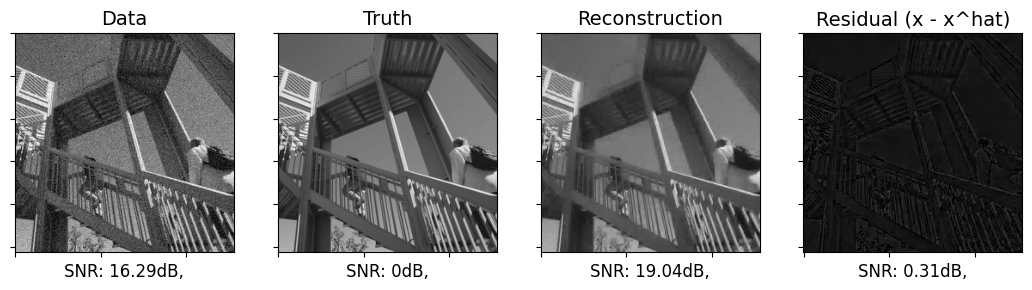

In [6]:
def eval_snr(x, x_est):
    if np.array_equal(x, x_est):
        return 0
    num = np.sqrt(np.sum(np.abs(x) ** 2))
    den = np.sqrt(np.sum(np.abs(x - x_est) ** 2))
    return round(20*np.log10(num/den), 2)

fig, axs = plt.subplots(1, 4, figsize=[13, 5])

titles = ["Data", "Truth", "Reconstruction", "Residual (x - x^hat)"]
est = [y, x, wvlt_best_estimate, x-wvlt_best_estimate]

for i in range(4):
    axs[i].imshow(est[i], cmap="gray", vmax=np.max(x), vmin=np.min(x))
    axs[i].set_title(titles[i], fontsize=14)
    axs[i].set_xlabel("SNR: {}dB,".format(eval_snr(x, est[i])), fontsize=12)

    plt.setp(axs[i].get_xticklabels(), visible=False)
    plt.setp(axs[i].get_yticklabels(), visible=False)

plt.show()

### Let's use the FB algorithm

In [7]:
reg_param_FB = 1.2e-2

# Define the grad
g = grad_operators.l2_norm(sigma, y, linear_operators.identity())
g.beta = 1.0 / sigma ** 2

# Define the wavelet dict
wav = ["db1", "db4"]                                     # Wavelet dictionaries to combine
levels = 4                                               # Wavelet levels to consider [1-6]
psi = linear_operators.dictionary(wav, levels, x.shape)  # Wavelet linear operator

# Define the l1 norm prox with the dict psi
h = prox_operators.l1_norm(np.max(np.abs(psi.dir_op(y))) * reg_param_FB, psi)
h.beta = 1.0

# Real prox 
# f = prox_operators.real_prox()
f = None

In [8]:
# Run the alg
alpha = 2 / (g.beta + 2)
wvlt_FB_best_estimate, wvlt_FB_diagnostics = opt.forward_backward.FB(x_init=y, options=options, g=g, f=f, h=h, alpha=alpha, tau=1)

wvlt_FB_best_estimate = np.abs(wvlt_FB_best_estimate)
# Why is it complex?!?!

# primal_dual.FBPD(y, options, g, f, h)


2023-01-30 16:05:58,009 - Optimus Primal - INFO - Running Base Forward Backward
2023-01-30 16:05:58,032 - Optimus Primal - INFO - [Forward Backward] 0 out of 1500 iterations, tol = 0.188327
2023-01-30 16:05:59,001 - Optimus Primal - INFO - [Forward Backward] 50 out of 1500 iterations, tol = 0.041772
2023-01-30 16:06:00,080 - Optimus Primal - INFO - [Forward Backward] 100 out of 1500 iterations, tol = 0.020998
2023-01-30 16:06:01,127 - Optimus Primal - INFO - [Forward Backward] 150 out of 1500 iterations, tol = 0.012689
2023-01-30 16:06:02,186 - Optimus Primal - INFO - [Forward Backward] 200 out of 1500 iterations, tol = 0.009888
2023-01-30 16:06:03,263 - Optimus Primal - INFO - [Forward Backward] 250 out of 1500 iterations, tol = 0.009179
2023-01-30 16:06:04,300 - Optimus Primal - INFO - [Forward Backward] 300 out of 1500 iterations, tol = 0.009091
2023-01-30 16:06:05,297 - Optimus Primal - INFO - [Forward Backward] 350 out of 1500 iterations, tol = 0.009137
2023-01-30 16:06:06,306 - O

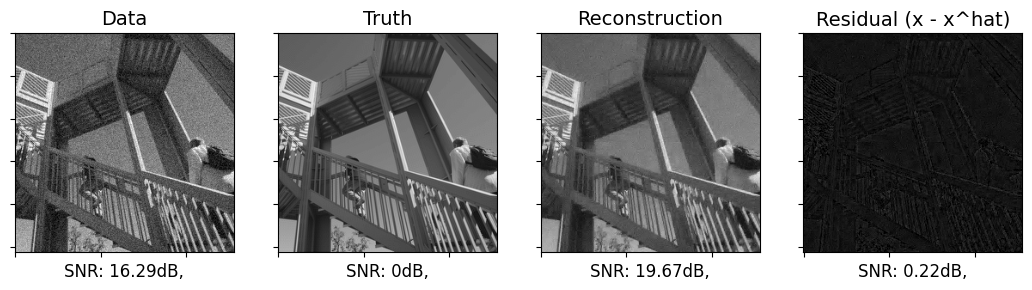

In [9]:
def eval_snr(x, x_est):
    if np.array_equal(x, x_est):
        return 0
    num = np.sqrt(np.sum(np.abs(x) ** 2))
    den = np.sqrt(np.sum(np.abs(x - x_est) ** 2))
    return round(20*np.log10(num/den), 2)

fig, axs = plt.subplots(1, 4, figsize=[13, 5])

titles = ["Data", "Truth", "Reconstruction", "Residual (x - x^hat)"]
est = [y, x, wvlt_FB_best_estimate, x-wvlt_FB_best_estimate]

for i in range(4):
    axs[i].imshow(est[i], cmap="gray", vmax=np.max(x), vmin=np.min(x))
    axs[i].set_title(titles[i], fontsize=14)
    axs[i].set_xlabel("SNR: {}dB,".format(eval_snr(x, est[i])), fontsize=12)

    plt.setp(axs[i].get_xticklabels(), visible=False)
    plt.setp(axs[i].get_yticklabels(), visible=False)

plt.show()

## CRR-based denoising

In [10]:
import torch
from convex_reg import utils
from tqdm import tqdm

gpu = False

if gpu:
    device = 'cuda:0'
    torch.set_grad_enabled(False)
    torch.set_num_threads(4)
else:
    device = 'cpu'
    

In [11]:
sigma_training = 25
t = 5
dir_name = '/Users/tliaudat/Documents/postdoc/github/convex_ridge_regularizers/trained_models/'
exp_name = f'Sigma_{sigma_training}_t_{t}/'
model = utils.load_model(dir_name+exp_name, device, gpu=gpu)

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183


In [12]:
y_torch = torch.tensor(y, device=device, dtype=torch.float32).reshape((1,1) + y.shape) # .to(torch.float32)
x_torch = torch.tensor(x, device=device, dtype=torch.float32).reshape((1,1) + x.shape) # .to(torch.float32)

In [13]:
print(y_torch.dtype)
print(y_torch.shape)

torch.float32
torch.Size([1, 1, 256, 256])


In [14]:
# optimization settings
tol = 1e-4
n_iter_max = 1500
lmbd = 6
mu = 20

# stepsize rule
L = model.L
alpha = 1. / ( 1. + mu * lmbd * L)

# initialization
x_hat = torch.clone(y_torch)
z = torch.clone(y_torch)
t = 1

for i in tqdm(range(n_iter_max)):
    x_hat_old = torch.clone(x_hat)
    x_hat = z - alpha*((z - y_torch) + lmbd * model(mu * z))
    # possible constraint, AGD becomes FISTA
    # e.g. if positivity
    # x = torch.clamp(x, 0, None)
    
    t_old = t 
    t = 0.5 * (1 + np.sqrt(1 + 4*t**2))
    z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

    # relative change of norm for terminating
    res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()
    if res < tol:
        break

 12%|█▏        | 181/1500 [00:11<01:20, 16.29it/s]


In [15]:
# crr_solution = x.detach().cpu().squeeze()


-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


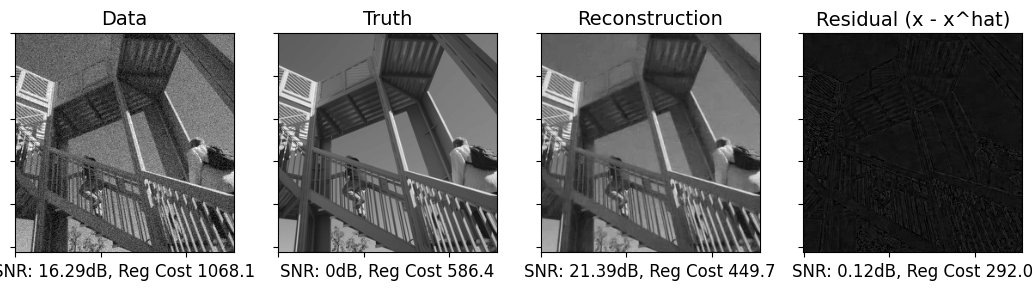

In [16]:
crr_solution = x_hat.detach().cpu().squeeze().numpy()


def eval_snr(x, x_est):
    if np.array_equal(x, x_est):
        return 0
    num = np.sqrt(np.sum(np.abs(x) ** 2))
    den = np.sqrt(np.sum(np.abs(x - x_est) ** 2))
    return round(20*np.log10(num/den), 2)

fig, axs = plt.subplots(1, 4, figsize=[13, 5])

titles = ["Data", "Truth", "Reconstruction", "Residual (x - x^hat)"]
est = [y, x, crr_solution, x-crr_solution]
est_torch = [y_torch, x_torch, x_hat, x_torch-x_hat]

for i in range(4):
    axs[i].imshow(est[i], cmap="gray", vmax=np.max(x), vmin=np.min(x))
    axs[i].set_title(titles[i], fontsize=14)
    axs[i].set_xlabel(f"SNR: {eval_snr(x, est[i])}dB, Reg Cost {model.cost(mu*est_torch[i])[0].item():.1f}", fontsize=12)

    plt.setp(axs[i].get_xticklabels(), visible=False)
    plt.setp(axs[i].get_yticklabels(), visible=False)

plt.show()



In [17]:

x_zeros = torch.zeros_like(x_hat)
model.cost(x_zeros)[0].item()


0.0